This Notebook and companion code is largely based on http://krasserm.github.io/2018/02/07/deep-face-recognition/ - a discussion about the OpenFace FaceNet implementation

# FaceNet in a Nutshell

FaceNet suggests one of 6 Neural Network architectures - This is NN4 Small - an Inception model with 96x96 images as input  

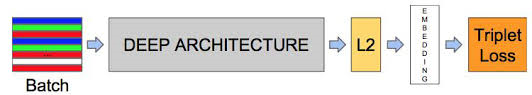

The input is 96x96x3 and the output is a 128d vector 

**Note: the last layer normalizes the embedding to be on the d-dim hyper sphere, with a distance of 1 from the 0-vector)**

Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ means $max(z,0)$ and $m$ is the number of triplets in the training set. The triplet loss in Keras is best implemented with a custom layer as the loss function doesn't follow the usual `loss(input, target)` pattern. This layer calls `self.add_loss` to install the triplet loss:

In [6]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
# emb_a = nn4_small2(in_a)
# emb_p = nn4_small2(in_p)
# emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
#triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Using a pre-trained OpenFace model on a custom dataset

Implementation of FaceNet trained on the public datasets FaceScrub and CASIA-WebFace

## Load the pre-trained model

In [74]:
import tensorflow as tf
nn4_small2_pretrained = tf.keras.models.load_model("nn4.small2.channel_first.h5")

## Prep the dataset

In [75]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext == ".png":
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [76]:
metadata = load_metadata('palo_images/')
metadata

array([tess_images/Bill_Gates/Bill_Gates_0002.jpg,
       tess_images/Bill_Gates/Bill_Gates_0007.jpg,
       tess_images/Bill_Gates/Bill_Gates_0006.jpg,
       tess_images/Bill_Gates/Bill_Gates_0004.jpg,
       tess_images/Bill_Gates/Bill_Gates_0003.jpg,
       tess_images/Bill_Gates/Bill_Gates_0001.jpg,
       tess_images/Bill_Gates/Bill_Gates_0009.jpg,
       tess_images/Bill_Gates/Bill_Gates_0005.jpg,
       tess_images/Bill_Gates/Bill_Gates_0008.jpg,
       tess_images/Bill_Gates/Bill_Gates_0010.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0006.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0002.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0008.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0009.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0001.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0003.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0010.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0007.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0004.jpg,
       tess_images/Tom_Hanks/Tom_Hanks_0005.jpg,


In [77]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# OpenCV loads images with color channels
# in BGR order. So we need to reverse them
def load_image(path):
    img = cv2.imread(path)
    return img # Do we need to reverse? need to check!!! nn4.small2.channel_first.h5 needs RGB or BGR
    #return img[...,::-1]


### Generate Embedding Vectors

In [78]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    #print(m.image_path())    
    img = load_image(m.image_path())
    #img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    progress.update(i)

ValueError: Error when checking input: expected input_5 to have shape (96, 96, 3) but got array with shape (250, 250, 3)

In [62]:
embedded[0]

array([ 0.05540419,  0.31075028,  0.13373359, -0.20228729, -0.32001022,
        0.43341941, -0.12574245,  0.38555783, -0.23057218,  0.01192024,
        0.20156512, -0.29175943,  0.15043831, -0.26733547,  0.28147012,
       -0.24688898, -0.14824095, -0.23226815,  0.02880124,  0.18947616,
        0.01458357, -0.11016319,  0.00442258,  0.30795246, -0.06489969,
       -0.04273435,  0.06070828, -0.285243  ,  0.29738685, -0.2721127 ,
        0.18620063, -0.2572023 ,  0.00111053,  0.17976329, -0.10053187,
        0.11025737,  0.07301082,  0.29575837, -0.07595548,  0.10085985,
        0.04967427, -0.4138543 , -0.4372932 , -0.03476512, -0.0637011 ,
        0.00832071,  0.2572448 ,  0.02400395, -0.71001768,  0.04086036,
       -0.35148823,  0.11165343,  0.1291694 ,  0.02632982, -0.13754626,
        0.11001568, -0.11067775,  0.11536674, -0.10452233, -0.46571189,
       -0.28706509,  0.20134118,  0.33766779, -0.29443875, -0.07236224,
        0.37454575,  0.39826205, -0.05978441, -0.14752193, -0.09

In [63]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

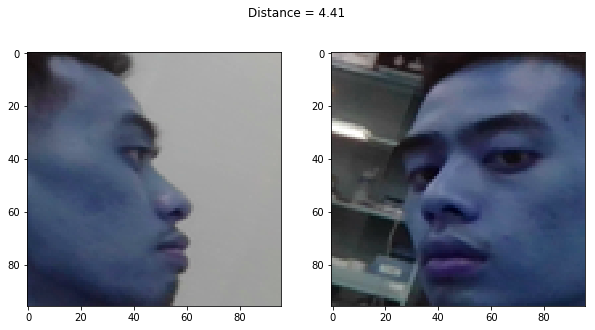

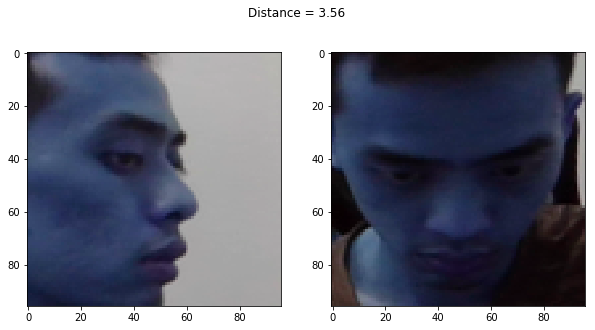

In [64]:
show_pair(10,30)
show_pair(8,1)

# What is the best threshold for the verification problem (Distance Treshold)

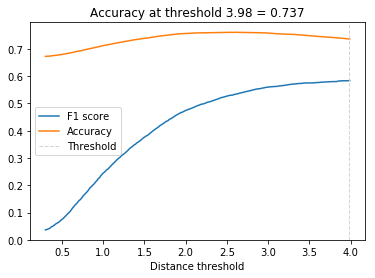

In [65]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 4.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

## Distance distributions of positive and negative pairs

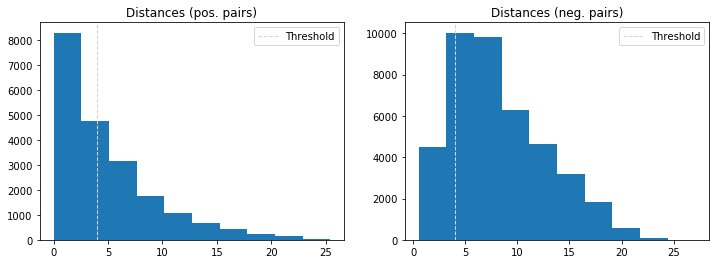

In [66]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Face recognition - with KNN or an SVM

50% used for training  
50% for validation

In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata.shape[0]) % 2 != 0
train_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = knn.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.967741935483871, SVM accuracy = 0.967741935483871


In [68]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = knn.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');        

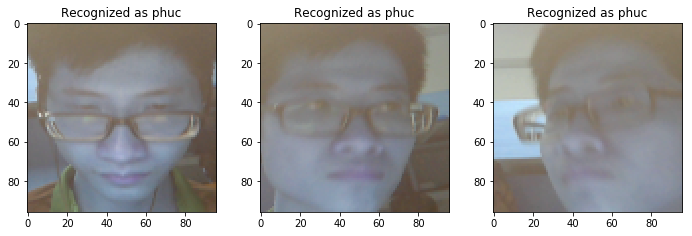

In [69]:
show_predictions(range(47,50))

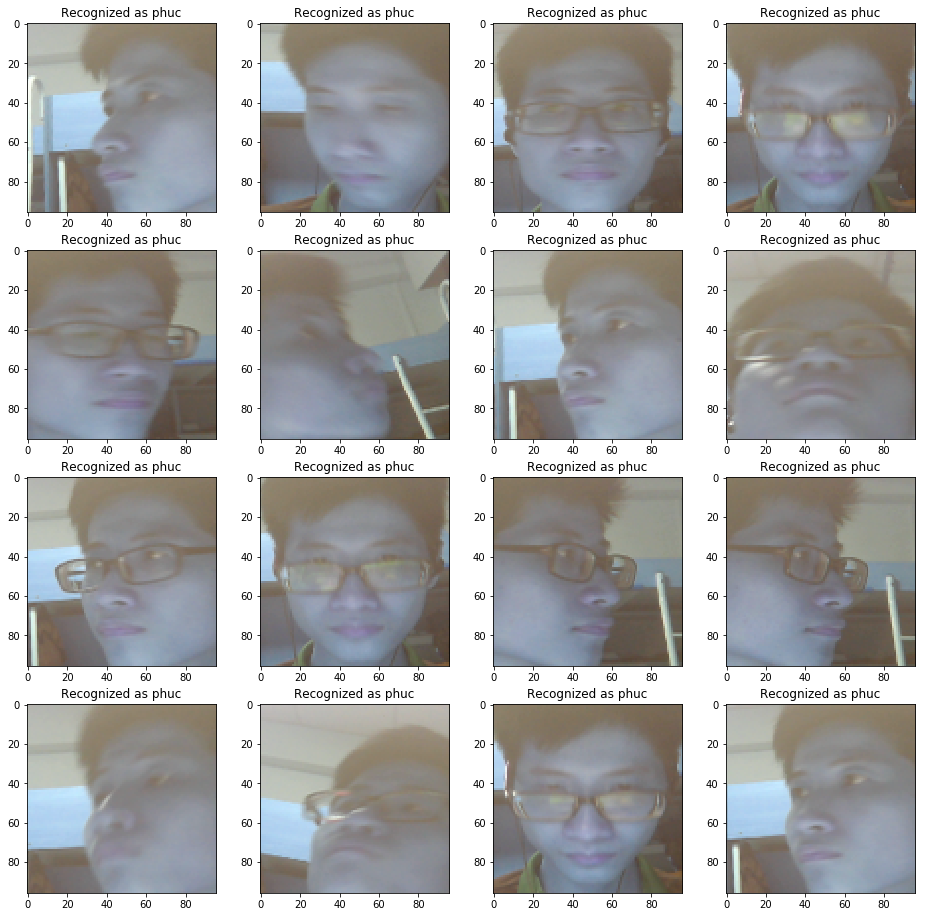

In [70]:
show_predictions(range(55,100))

## Missclassified images

[25, 27, 38, 100]


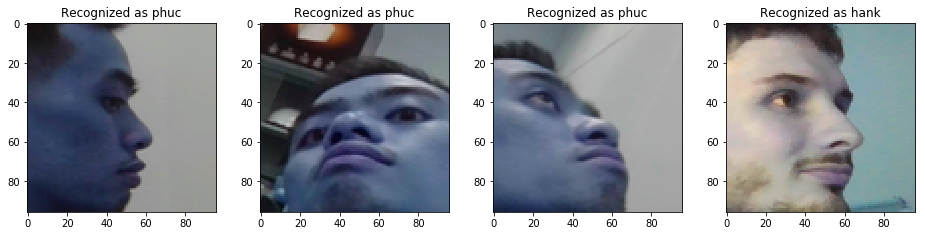

In [71]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)


# Dataset visualization

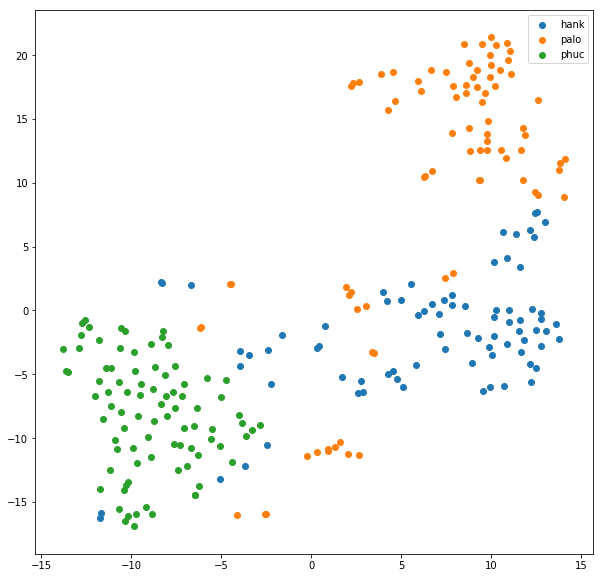

In [72]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

NameError: name 'embedding' is not defined